# Analizando patrones de movilidad en Ecobici Octubre de 2019

Como práctica guiada para esta clase la sugerencia es producir una visualizacion que contenga al menos un mapa que de cuenta de los patrones de movilidad de los usuarios de EcoBici. Esto puede implicar:

- Visualizar las estaciones más demandadas desde el punto de vista de los orígenes o los destinos.

- Visualizar como cambia este comportamiento en el tiempo.

- Visualizar viajes como lineas para observar los viajes más comunes. Esto puede implicar algún estadistico resumen para cada par Origen-Destino que quede representado geográficamente en una linea o cualquier otra decisión que prefieran. Pueden elegir mapear por ejemplo las estaciones que concentran el 50% de los viajes usando el color, tamaño, transparencia o todos esos componentes como elementos para visualizar.

- Pueden ver la estación con más orígenes-destinos, o que quede en algun lugar particular por su entorno urbano (estaciones de FFCC) y observar los viajes que tengan esa estacion como Origen o Destino. Por ejemplo, a donde van los viajes que se inician en estación Constitución por la mañana.      



In [1]:
#instalo geopandas 
!pip install geopandas mapclassify contextily

     |████████████████████████████████| 972kB 4.9MB/s 
     |████████████████████████████████| 6.5MB 22.7MB/s 
     |████████████████████████████████| 14.8MB 300kB/s 
     |████████████████████████████████| 18.3MB 1.2MB/s 


In [2]:
#importo las librerias necesarias (puede que necesiten importar mas depende lo que quieran hacer)
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
#descargo un subset de datos paa octubr de Ecobici
#pueden usar la totalidad de los viajes de esta url (pesa 1.5Gb) 
# 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/bicicletas-publicas/recorridos-realizados-2019.csv'
!wget 'https://github.com/alephcero/untref_analisis_espacial_2020/raw/master/data/ecobici_2019_octubre.zip'

--2020-11-13 00:40:36--  https://github.com/alephcero/untref_analisis_espacial_2020/raw/master/data/ecobici_2019_octubre.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alephcero/untref_analisis_espacial_2020/master/data/ecobici_2019_octubre.zip [following]
--2020-11-13 00:40:37--  https://raw.githubusercontent.com/alephcero/untref_analisis_espacial_2020/master/data/ecobici_2019_octubre.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18648355 (18M) [application/zip]
Saving to: ‘ecobici_2019_octubre.zip’

ecobici_2019_octubr 100%[===================>]  17.78M  62.4MB/s    in 0.3s    

2020-11-

In [4]:
# no es necesario descomprimir el archivo ya que pandas abre un zip
viajes = pd.read_csv('ecobici_2019_octubre.zip')

In [5]:
viajes.sample(4)

,id_usuario,edad_usuario,genero_usuario,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,capacidad_estacion_origen,lat_estacion_origen,long_estacion_origen,duracion_recorrido,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,capacidad_estacion_destino,lat_estacion_destino,long_estacion_destino,servicio
313293,292615,NaN,NaN,2019-10-22 17:45,170.0,170 - SAN LUIS Y ECUADOR,San Luis 2862,20.0,-34.599664,-58.406102,0 days 00:25:30.000000000,2019-10-22 18:10,273.0,223 - GAINZA,"Gainza, Martin De, Gral. 494",16.0,-34.616680,-58.446667,antiguo
192939,523891,NaN,NaN,2019-10-31 12:42,141.0,141 - SOLIS Y ALSINA,Solis 225,20.0,-34.611523,-58.390497,0 days 00:36:15.000000000,2019-10-31 13:18,249.0,307 - LEONARDO PEREYRA,California 2990,16.0,-34.649843,-58.388562,antiguo
188944,461278,NaN,NaN,2019-10-30 14:28,8.0,008 - Congreso,"Cevallos, Virrey y Yrigoyen, Hipolito Av.",24.0,-34.609422,-58.389336,0 days 00:17:18.000000000,2019-10-30 14:45,8.0,008 - Congreso,"Cevallos, Virrey y Yrigoyen, Hipolito Av.",24.0,-34.609422,-58.389336,antiguo
729997,183046,NaN,NaN,2019-10-26 12:44,391.0,295 - Larralde,Vidal 3607,20.0,-34.550894,-58.471918,0 days 00:21:43.000000000,2019-10-26 13:06,248.0,346 - Plaza Zapiola,Donado 2001,20.0,-34.573841,-58.474281,antiguo


In [6]:
def_list = []
nombres_columnas = ['id','nombre','direccion','lat','long']

#para cada tipo de estacion (origen o destino)
for tipo in ['origen','destino']:
  #obtenemos las columnas que queremos y corresponden a ese tipo
  columnas_reindexar = list(map(lambda col: col + '_estacion_' + tipo,nombres_columnas))
  estaciones_tipo = viajes.reindex(columns = columnas_reindexar)
  #cambiamos los nombres a un estandar comun
  estaciones_tipo.columns = nombres_columnas

  #las agregamos a la lista
  def_list.append(estaciones_tipo)

#concatenamos 
estaciones = pd.concat(def_list).drop_duplicates(subset=['lat','long'])

print('hay algunas estaciones con ud duplicado?:', any(estaciones['id'].duplicated()))
print('tenemos %i estaciones' % len(estaciones))

#crear un geopandas GeoDataFrame
estaciones = gpd.GeoDataFrame(
    estaciones, geometry=gpd.points_from_xy(estaciones['long'], estaciones['lat']),crs='EPSG:4326')

hay algunas estaciones con ud duplicado?: False
tenemos 395 estaciones


In [ ]:
estaciones.plot()

In [7]:
viajes = viajes.loc[viajes.id_estacion_destino != viajes.id_estacion_origen,:]
viajes['fecha'] = pd.to_datetime(viajes.fecha_origen_recorrido,errors='coerce')
viajes['dia'] = viajes.fecha.dt.day

viajes = viajes.loc[viajes['fecha'].dt.weekday == 2,['dia','id_estacion_origen','id_estacion_destino']]
viajes['n']=1
viajes = viajes.groupby(['dia','id_estacion_origen','id_estacion_destino'],as_index=False).sum().sort_values('n',ascending=False)
viajes.drop('dia',axis=1,inplace=True)
viajes = viajes.groupby(['id_estacion_origen','id_estacion_destino'],as_index=False).mean().sort_values('n',ascending=False)

viajes = viajes.loc[viajes['n'] >1] 

# arego info origen
viajes = viajes.merge(estaciones.reindex(columns = ['id','nombre','geometry']), 
                      left_on = 'id_estacion_origen',right_on = 'id',
                      how='left'
                      )
viajes.rename(columns = {'geometry':'geom_origen',
                         'nombre':'nombre_origen'},inplace=True)
viajes.drop(['id'],axis=1,inplace=True)

viajes = viajes.merge(estaciones.reindex(columns = ['id','nombre','geometry']), 
                      left_on = 'id_estacion_destino',right_on = 'id',
                      how='left'
                      )
viajes.rename(columns = {'geometry':'geom_destino',
                         'nombre':'nombre_destino'},inplace=True)
viajes.drop(['id'],axis=1,inplace=True)

viajes.sample(5)

,id_estacion_origen,id_estacion_destino,n,nombre_origen,geom_origen,nombre_destino,geom_destino
2973,400.0,336.0,2.25,313 - De Los Incas,POINT (-58.47100 -34.57975),207 - PLAZA ARENALES,POINT (-58.51142 -34.59992)
14231,304.0,269.0,1.25,395 - Agronomia II,POINT (-58.48420 -34.58941),260 - SAN MIGUEL DE GARICOITS,POINT (-58.45785 -34.57730)
6374,293.0,281.0,2.00,294 - Bonifacio,POINT (-58.43244 -34.62649),350 - Plaza Irlanda,POINT (-58.45837 -34.61388)
438,265.0,343.0,4.20,361 - Plaza Don Segundo Sombra,POINT (-58.45066 -34.64188),219 - Parque Chacabuco II,POINT (-58.44116 -34.63573)
997,179.0,252.0,3.20,179 - LA BOCA,POINT (-58.36053 -34.63899),331 - PLAZA HERRERA,POINT (-58.37621 -34.64452)


In [8]:
from shapely.geometry import LineString
def crear_linea(fila):
  return LineString([fila.geom_origen,fila.geom_destino])

geometrias = viajes.apply(crear_linea,axis=1)

viajes = gpd.GeoDataFrame(
    viajes, geometry=geometrias,crs='EPSG:4326')
viajes = viajes.to_crs(epsg = 3857)

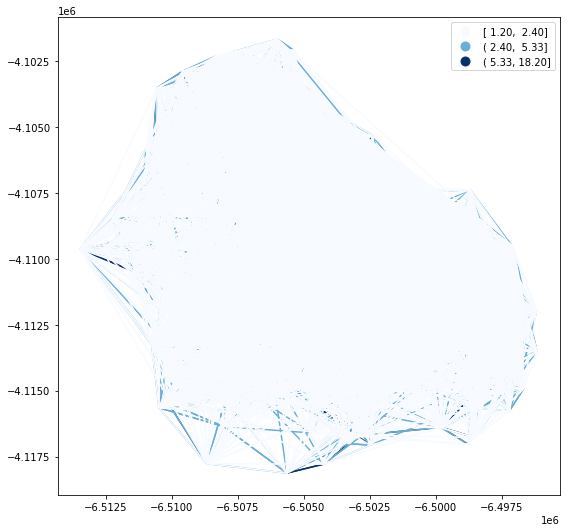

In [10]:
f,ax = plt.subplots(figsize=(9,9))
viajes.plot(
            column = 'n',
            scheme = 'FisherJenks',
            k=3,
            cmap = 'Blues',
            ax=ax,
             legend = True)

In [11]:
from matplotlib.colors import ListedColormap

In [12]:
#paleta cuantitativa
cm = plt.get_cmap('Blues')
colores = cm([0,.5,1])
colores[0][3] = 0.05
colores[1][3] = 0.2
colores[2][3] = 1
colores

array([[0.96862745, 0.98431373, 1.        , 0.05      ],
       [0.41708574, 0.68063053, 0.83823145, 0.2       ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])

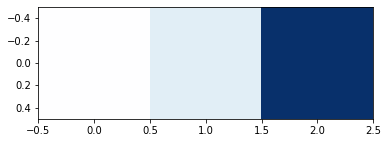

In [13]:
cuanti = ListedColormap(colores)
plt.imshow([colores])

In [14]:
#paleta cuali
cm = plt.get_cmap('Dark2')
colores = cm.colors[:3]
colores = [list(c) for c in colores]
cuali = ListedColormap(colores)

colores_alpha = cm.colors[:3]
colores_alpha = [list(c) for c in colores_alpha]
colores_alpha[0].append(0.01)
colores_alpha[1].append(0.2)
colores_alpha[2].append(1)
cuali_alpha = ListedColormap(colores_alpha)


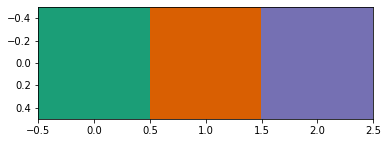

In [15]:
cuali = ListedColormap(colores)
plt.imshow([colores])

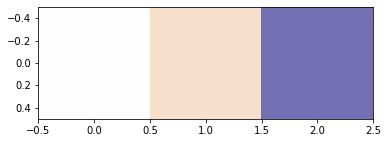

In [16]:
plt.imshow([colores_alpha])

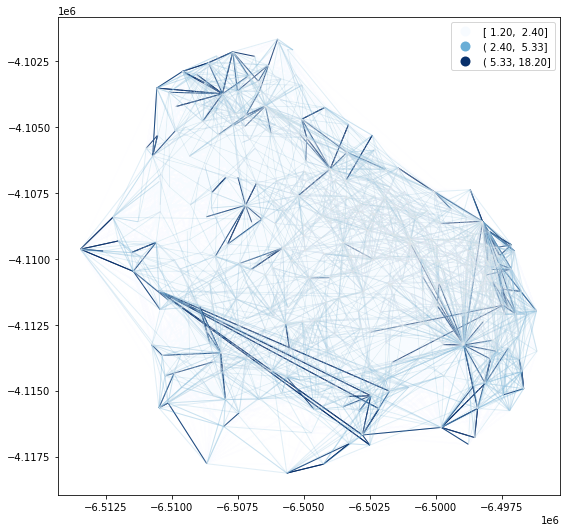

In [17]:
f,ax = plt.subplots(figsize=(9,9))
viajes.plot(
            column = 'n',
            scheme = 'FisherJenks',
            linewidth = viajes['n'] ** 0.003,
            k=3,
            cmap = cuanti,
            ax=ax,
            legend = True)

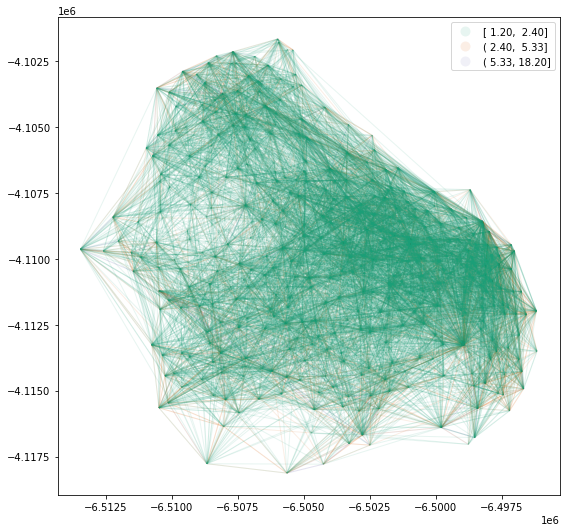

In [18]:
f,ax = plt.subplots(figsize=(9,9))
viajes.plot(alpha = 0.1,
            column = 'n',
            scheme = 'FisherJenks',
            linewidth = viajes['n'] ** 0.003,
            k=3,
            cmap = cuali,
            ax=ax,
            legend = True)

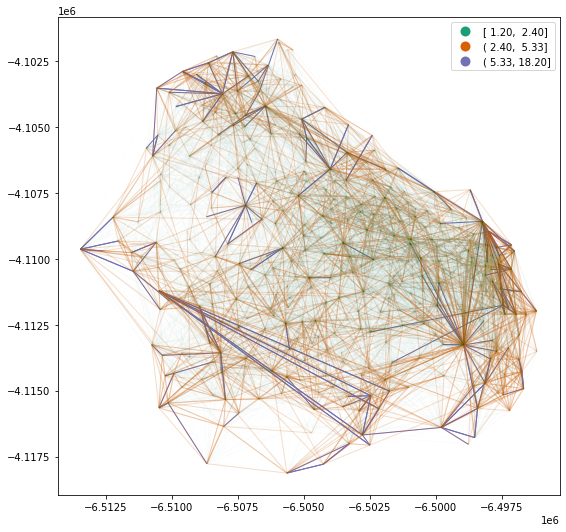

In [19]:
f,ax = plt.subplots(figsize=(9,9))
viajes.plot(
            column = 'n',
            scheme = 'FisherJenks',
            linewidth = viajes['n'] ** 0.003,
            k=3,
            cmap = cuali_alpha,
            ax=ax,
            legend = True)

1.6666666666666667

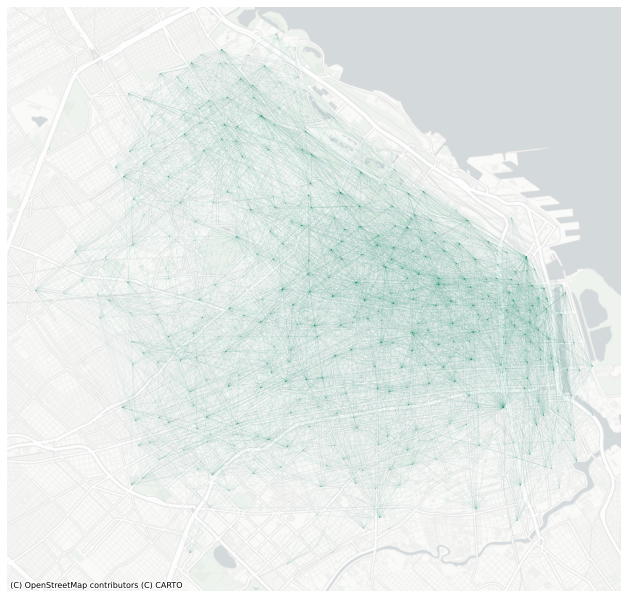

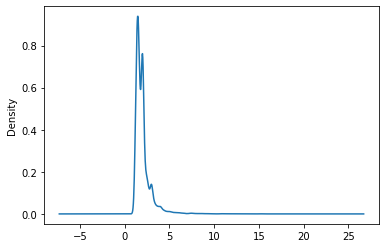

In [24]:
from sklearn.cluster import KMeans


In [60]:
X = viajes['n'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
viajes['k'] = kmeans.labels_
viajes['k'].value_counts(normalize = True)

1    0.825128
0    0.159877
2    0.014995
Name: k, dtype: float64

In [62]:
promedios_k = viajes.reindex(columns =['k','n']).groupby('k').median()
promedios_k

,n
k,
0,3.000000
1,1.666667
2,6.600000


In [64]:
import seaborn as sns

In [66]:
percentil = .05
viajes['p'] = viajes['n']/viajes['n'].sum()
viajes['p_cumsum'] = viajes['p'].cumsum()
id_percentil = (viajes['p'].cumsum() - percentil).abs().idxmin()
#od_percentil = viajes.loc[:id_percentil]
od_percentil = viajes.loc[viajes.k == 2,:]
od_heatmap = od_percentil.reindex(columns = ['nombre_origen','nombre_destino','n'])
od_heatmap = od_heatmap.pivot(index='nombre_origen', columns='nombre_destino', values='n').fillna(0)
od_heatmap

nombre_destino,001 - FACULTAD DE DERECHO,003 - ADUANA,004 - Plaza Roma,005 - Plaza Italia,006 - Parque Lezama,010 - Madero UCA,014 - Pacifico,021 - Parque Patricios,028 - Plaza Boedo,055 - Bouchard,063 - Reconquista,073 - Ruy Díaz de Guzmán,076 - Ayacucho,082 - HOSPITAL ITALIANO,092 - Salcedo,094 - GÚZMAN,096 - Carlos Gardel,103 - MALBA,104 - Federico Lacroze,111 - MACACHA GUEMES,114 - DELLA PAOLERA,127 - SANTOS DUMONT Y OTERO,128 - PARQUE DEL BAJO,130 - RETIRO II,132 - CORRIENTES,136 - Acevedo,137 - AZOPARDO Y CHILE,147 - Constitución,150 - VERA PEÑALOZA,151 - AIME PAINÉ,155 - Parque José Evaristo Uriburu,156 - Plaza Alemania,159 - Fitz Roy & Gorriti,160 - Godoy Cruz y Libertador,164 - FACULTAD DE INGENERIA,172 - BRASIL,176 - PINZÓN Y MARTÍN RODRIGUEZ,177 -PLANETARIO,179 - LA BOCA,183 - VIRREY CEVALLOS,...,289 - MONTAÑESES,292 - PLAZA BOLIVIA,295 - Larralde,297 - TRONADOR Y GARCÍA DEL RÍO,300 - Jose Artigas,302 - Plaza Jose Marti,305 - Plaza Martin Rodriguez,306 - Tres Arroyos Y Olaya,307 - LEONARDO PEREYRA,308 - Artigas Y Melincue,315 - BEIRO Y SAN MARTÍN,323 - Parque Avellaneda II,330 - Parque Avellaneda,331 - PLAZA HERRERA,336 - La Pampa,337 - UTN,339 - AMANCIO ALCORTA,340 - PLAZA NUEVA POMPEYA,341 - TILCARA,342 - SAENZ,343 - POMAR,344 - UNIVERSIDAD DI TELLA,348 - Villa del Parque,352 - San Jose de Flores,353 - PLAZA VELEZ SARSFIELD,354 - Plaza Tupac Amaru,356 - Plaza Sergio Karakachoff,359 - Plaza Balcarce,363 - Udaondo,366 - Plaza Diaz Velez,369 - Ciudad De La Paz,372 - Villa Soldati,379 - BERG,381 - Matienzo Y Arce,382 - CMD,388 - Plaza Jose C Paz,390 - De Los Ombues,391 - Plaza República de Ecuador,393 - Barrio 31,399 - GARCIA DEL RIO
nombre_origen,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001 - FACULTAD DE DERECHO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003 - ADUANA,0.0,0.0,0.0,0.0,0.0,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.6,0.0,0.0,0.0,0.0,0.0,9.6,5.6,0.0,0.0,0.0,0.0,7.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004 - Plaza Roma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005 - Plaza Italia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008 - Congreso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394 - Av. La Plata,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


''

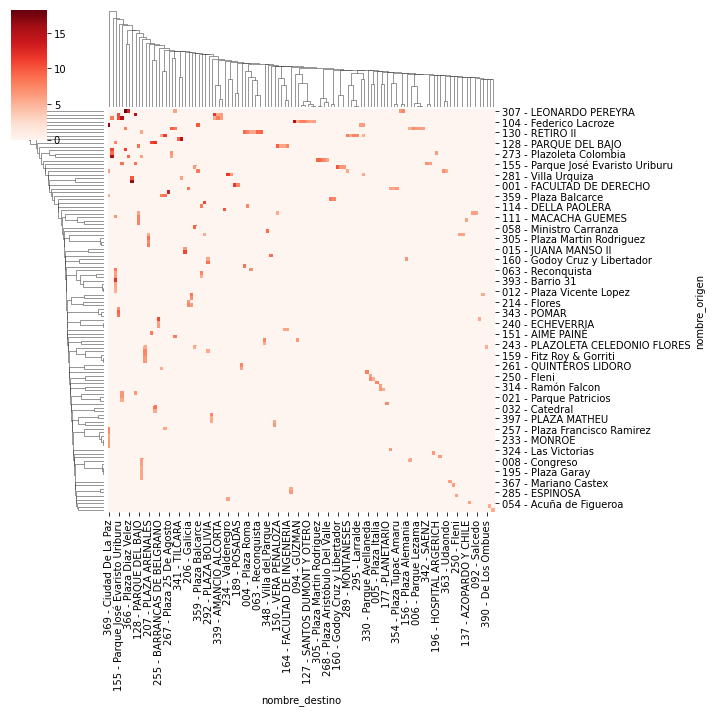

In [86]:
g = sns.clustermap(od_heatmap,cmap='Reds')
;

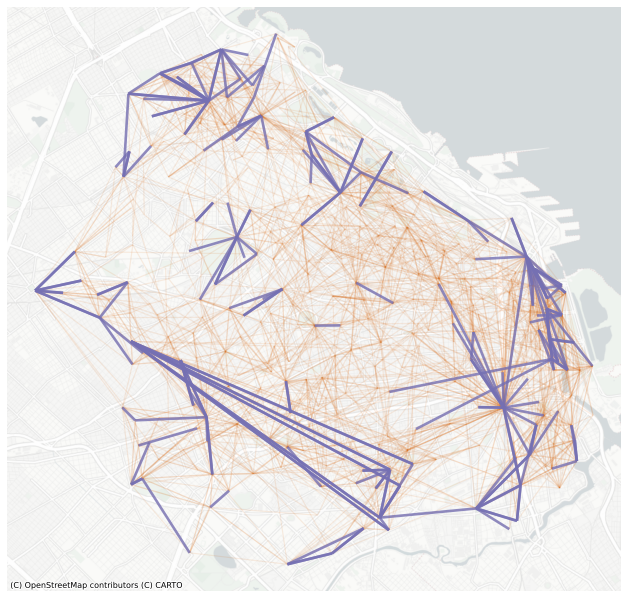

In [118]:
f,ax = plt.subplots(figsize=(11,11))

viajes.loc[viajes.k ==0].plot(
    alpha = 0.1,
            linewidth = promedios_k.loc[0,'n'] /2.5,
            color = colores[1],
            ax=ax)

viajes.loc[viajes.k ==2].plot(
    alpha = 0.8,
            linewidth = promedios_k.loc[2,'n'] /2.5,
            color = colores[2],
            ax=ax)


ctx.add_basemap(ax,
                source = ctx.providers.CartoDB.PositronNoLabels,
                crs = viajes.crs.to_string())

ax.set_axis_off()